# Marker annotation by SEMITONES (calculating escore of markers) 

#### Note that we are in Python

#### Working directory must contain subdirectories,supp_data

#### supp_data/ should contain the files, which are available on Github (github.com/Hsu-Che-Wei/COPILOT):

    Root_Atlas_SCT_expr.h5ad (get it by running through notebook 4-1)  
    markers_for_SEMITONES.txt
    hvg_ids.txt 
    r_cells.txt
    umap50.txt (get it by running through notebook 4-2)
    umap.txt (get it by running through notebook 4-2)

### 1. Import all needed functions

In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from SEMITONES.enrichment_scoring import calculate_escores
from SEMITONES.enrichment_scoring import permute, sig_interval
from SEMITONES.support_funcs import load_sparse_h5, pairwise_similarities
from SEMITONES.support_funcs import sig_dictionary
import anndata

### 2. Load the data

#### a. Gene x cell expression matrix
I use matrices where rows are cells and columns are genes. I am not sure what data format you use, so if you cannot figure out how to load the data, please let me know. If you do not use sparse matrix formats, I would advise you to do so to prevent high memory requirements during the scoring. For this, you can take your matrix and use the csr_matrix function from scipy.sparse.

For this example, I use a subsetted matrix with only the most highly dispersed genes.

In [2]:
SCT = anndata.read_h5ad("./supp_data/Root_Atlas_SCT_expr.h5ad")

In [3]:
SCT

AnnData object with n_obs × n_vars = 110427 × 24997
    obs: 'CytoTRACE', 'celltype.anno', 'time.anno', 'time.celltype.anno', 'consensus.time', 'consensus.time.group'
    obsm: 'X_pca', 'X_umap'

In [4]:
HVG = SCT.X

In [5]:
type(HVG)

scipy.sparse.csc.csc_matrix

In [6]:
HVG.shape

(110427, 24997)

In [7]:
# Load marker id 
fname = "./supp_data/markers_for_SEMITONES.txt"
with open(fname, "r") as f:
    cols_to_keep = [int(cell.strip("\n")) for cell in f.readlines()]
f.close()

In [8]:
HVG = HVG[:, cols_to_keep]

In [9]:
HVG.shape

(110427, 46)

In [10]:
fname = "./supp_data/hvg_ids.txt"
with open(fname, "r") as f:
    hvg_names = [gene.strip("\n") for gene in f.readlines()]
f.close()

In [11]:
type(hvg_names)

list

In [12]:
len(hvg_names)

24997

In [13]:
hvg_names = list( hvg_names[i] for i in cols_to_keep )

In [14]:
len(hvg_names)

46

In [15]:
hvg_names

['AT1G79840',
 'AT3G28540',
 'AT5G48130',
 'AT1G17400',
 'AT1G33280',
 'AT4G10350',
 'AT1G79580',
 'AT1G62500',
 'AT1G62510',
 'AT2G40260',
 'AT2G29330',
 'AT3G56220',
 'AT3G61930',
 'AT1G16390',
 'AT1G30750',
 'AT3G54220',
 'AT4G16270',
 'AT5G46600',
 'AT5G57620',
 'AT5G14750',
 'AT5G19530',
 'AT2G31310',
 'AT1G79430',
 'AT4G36410',
 'AT5G04080',
 'AT2G22850',
 'AT1G04240',
 'AT1G71050',
 'AT1G71930',
 'AT3G25710',
 'AT4G18780',
 'AT2G04025',
 'AT2G18380',
 'AT5G62940',
 'AT3G20880',
 'AT3G26120',
 'AT5G60810',
 'AT3G55550',
 'AT3G60650',
 'AT1G66470',
 'AT4G13390',
 'AT5G37800',
 'AT5G49270',
 'AT5G58010',
 'AT2G36120',
 'AT4G30450']

#### b. Reference cells

In [16]:
fname = "./supp_data/r_cells.txt"
with open(fname, "r") as f:
    r_cells = [int(cell.strip("\n")) for cell in f.readlines()]
f.close()

In [17]:
r_cells = np.arange(HVG.shape[0])

In [18]:
r_cells = r_cells.tolist()

In [19]:
type(r_cells)

list

In [20]:
len(r_cells)

110427

#### c. UMAP for similarity calculations

In [21]:
UMAP_50 = np.loadtxt("./supp_data/umap50.txt")  # or load your preferred representation

#### d. UMAP for visualization

In [22]:
UMAP = np.loadtxt("./supp_data/umap.txt")

### 3. Enrichment scoring

#### i. Define the similarity matrix
Here, you use the metric selected in notebook 2.

In [23]:
metric = "rbf"  # replace
gamma = 0.8  # only use if laplacian, sigmoid or rbf and replace by wished value
S = pairwise_similarities(UMAP_50, r_cells, metric=metric,
                          metric_params={"gamma": gamma}  # only use if needed
                         )

In [24]:
S.shape

(110427, 110427)

#### ii. Calculate the enrichment scores
I use gene expression values which were nog previously scaled, so I scale them in function. If you use scaled data, set this to false. Also, if you want to identify very lowly and specifically expressed genes, set this to False.

In [25]:
escores = calculate_escores(HVG, r_cells, S=S, optim_over="rows", scale_exp=False)

Start enrichment scoring using 160 CPUs
Creating process pool
Run enrichment scoring
Enrichment scoring complete


The escores dataframe is a dataframe of size genes x r_cells. The order of genes is preserved, so you can map them back to the indices of the genes in the original data. Take care here that in Python, counting starts at 0 and not 1. If you need any help here, let me know. Below, I manually set the gene names to the index.

In [26]:
escores.index = hvg_names

In [27]:
escores.index

Index(['AT1G79840', 'AT3G28540', 'AT5G48130', 'AT1G17400', 'AT1G33280',
       'AT4G10350', 'AT1G79580', 'AT1G62500', 'AT1G62510', 'AT2G40260',
       'AT2G29330', 'AT3G56220', 'AT3G61930', 'AT1G16390', 'AT1G30750',
       'AT3G54220', 'AT4G16270', 'AT5G46600', 'AT5G57620', 'AT5G14750',
       'AT5G19530', 'AT2G31310', 'AT1G79430', 'AT4G36410', 'AT5G04080',
       'AT2G22850', 'AT1G04240', 'AT1G71050', 'AT1G71930', 'AT3G25710',
       'AT4G18780', 'AT2G04025', 'AT2G18380', 'AT5G62940', 'AT3G20880',
       'AT3G26120', 'AT5G60810', 'AT3G55550', 'AT3G60650', 'AT1G66470',
       'AT4G13390', 'AT5G37800', 'AT5G49270', 'AT5G58010', 'AT2G36120',
       'AT4G30450'],
      dtype='object')

##### iii. Get signficantly enriched genes
The significantly enriched genes can have both negative or positive scores. If the score is positive, a gene is overexpressed in the reference cell. If the score is negative, a gene is repressed in the reference cells.

Permute the dataframe. This takes a little while.

In [28]:
n = 100  # how many times to permute the dataframe
seed = 42  # set this for reproducibility
P = permute(HVG, n=n, seed=seed, axis=0)

Calculate scores for the permuted expression values. Make sure to pass the permuted dataframe and keep all other parameters the same.

In [29]:
pscores = calculate_escores(P, r_cells, S=S, optim_over="rows", scale_exp=False)

Start enrichment scoring using 160 CPUs
Creating process pool
Run enrichment scoring
Enrichment scoring complete


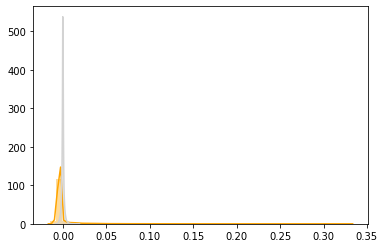

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(escores.values.ravel(), color="orange")
sns.distplot(pscores.values.ravel(), color="lightgrey")
plt.show()

Determine the significance cut-offs

In [31]:
n_sds = 5  # the number of SDs away from the mean for significance
cutoffs = sig_interval(pscores, n_sds=n_sds)

Get a dictionary of significant genes per cell

In [32]:
sigs = sig_dictionary(escores, cutoffs, retrieve="cols")

In [33]:
df = pd.DataFrame({key: pd.Series(value) for key, value in sigs.items()})
df.to_csv("./supp_data/semitones.curated.marker.anno.nsds5.csv", encoding='utf-8', index=False)

In [34]:
escores.to_csv("./supp_data/semitones.curated.marker.csv", encoding='utf-8', index=False)

In [35]:
n_sds = 10  # the number of SDs away from the mean for significance
cutoffs = sig_interval(pscores, n_sds=n_sds)
sigs = sig_dictionary(escores, cutoffs, retrieve="cols")

In [36]:
df = pd.DataFrame({key: pd.Series(value) for key, value in sigs.items()})
df.to_csv("./supp_data/semitones.curated.marker.anno.nsds10.csv", encoding='utf-8', index=False)

In [37]:
n_sds = 15  # the number of SDs away from the mean for significance
cutoffs = sig_interval(pscores, n_sds=n_sds)
sigs = sig_dictionary(escores, cutoffs, retrieve="cols")

In [38]:
df = pd.DataFrame({key: pd.Series(value) for key, value in sigs.items()})
df.to_csv("./supp_data/semitones.curated.marker.anno.nsds15.csv", encoding='utf-8', index=False)

In [39]:
n_sds = 20  # the number of SDs away from the mean for significance
cutoffs = sig_interval(pscores, n_sds=n_sds)
sigs = sig_dictionary(escores, cutoffs, retrieve="cols")

In [40]:
df = pd.DataFrame({key: pd.Series(value) for key, value in sigs.items()})
df.to_csv("./supp_data/semitones.curated.marker.anno.nsds20.csv", encoding='utf-8', index=False)